In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50

In [3]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "DATASET",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 35911 files belonging to 27 classes.


In [4]:
class_names = dataset.class_names
class_names

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice__Bacterial_leaf_blight',
 'Rice__Brown_spot',
 'Rice__Leaf_smut',
 'Soybean___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [7]:
len(dataset)   

1123

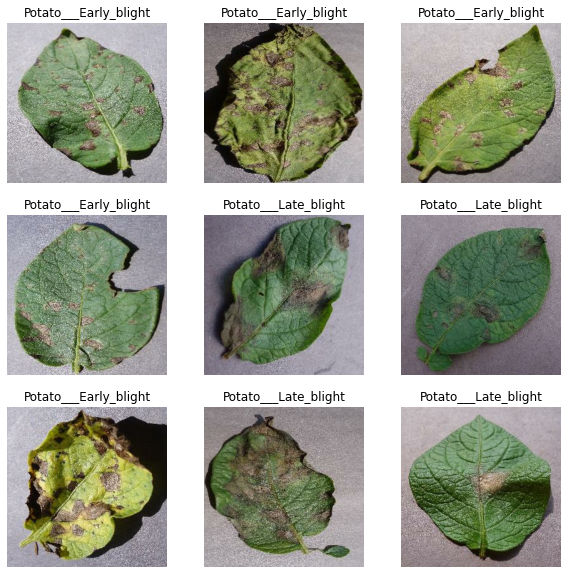

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis(False)

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
rest_ds = dataset.skip(54)
val_size = 0.1
test_size = 0.1

In [12]:
test_size*len(dataset)

6.800000000000001

In [13]:
val_ds = rest_ds.take(6)
test_ds = rest_ds.skip(6)
print(len(val_ds),len(test_ds))

6 8


In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
train_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds =  val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds =  test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Reprocess the modal before training by flip and rotation 

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    ])

### CNN

In [24]:
INPUT_SHAPE = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
N_CLASSES = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = INPUT_SHAPE),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')
])

model.build(input_shape = INPUT_SHAPE)

There is a bug in keras/tensorflow 2.9 and 2.10, which causes preprocess layers like rescaling to be extremly slow: https://github.com/tensorflow/tensorflow/issues/56242

In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [26]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [27]:
history = model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 176s 3s/step - loss: 0.9042 - accuracy: 0.4936 - val_loss: 0.9170 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 107s 2s/step - loss: 0.7118 - accuracy: 0.6615 - val_loss: 0.5359 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 103s 2s/step - loss: 0.4243 - accuracy: 0.8287 - val_loss: 0.3963 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 99s 2s/step - loss: 0.3197 - accuracy: 0.8646 - val_loss: 0.2931 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 101s 2s/step - loss: 0.3499 - accuracy: 0.8536 - val_loss: 0.2742 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 105s 2s/step - loss: 0.2119 - accuracy: 0.9057 - val_loss: 0.3753 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 113s 2s/step - loss: 0.1942 - accuracy: 0.9178 - val_loss: 0.5122 - val_accuracy: 0.8021
Epoch 8/50
54/